In [23]:
from regain.datasets.hmm import generate_hmm
from regain.hmm.higher_order_hmm_graphical_lasso import HHMM_GraphicalLasso
import numpy as np
from importlib import reload
import regain.hmm.utils; reload(regain.hmm.utils)
from regain.hmm.utils import results_recap
from regain.hmm.utils import cross_validation_higher_order,spread_pred_interpretation
import pickle as pkl
#from notebooks.hmm.pred_func import pred_lgb, pred_LSTM, pred_VAR_VARMA, pred_Kernel_Ridge,pred_HMM_GMM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [68]:
N_samples = 3000
N_states = 2
Mem = 3
N_TS = 10
sigma_Normal = 1

dataset = generate_hmm(n_samples= N_samples,
                       n_states=N_states,
                       n_dim_obs=N_TS,
                       mode_precisions='regain_random',
                       mode_mean = 'Normal',
                       transition_type='fixed',
                       sigma=sigma_Normal,
                       order_hmm = Mem)

[2029.25533832 2040.89622333 2077.51044036 2043.04112173 2075.72720598
 2088.10454365 2095.05236363 2057.92939122 2040.40536506 2028.16831604]


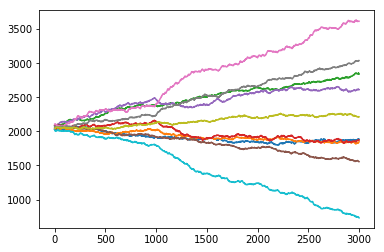

In [69]:
p_vec_0 = np.random.uniform(0,100,N_TS)+2000
Data = np.zeros((np.size(dataset['data'],axis=0),N_TS))
print(p_vec_0)
for j in range(N_TS):
    #print(p_vec_0[j])
    #print(np.cumsum(dataset['data'][:,j]))
    plt.plot(p_vec_0[j]+np.cumsum(dataset['data'][:,j]))
    Data[:,j] = p_vec_0[j]+np.cumsum(dataset['data'][:,j])
    
plt.show()

In [70]:
lam = 12
max_iter = 1000

mdl = HHMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=5,
                         n_jobs=-1,
                         N_memory_trans = Mem,
                         N_memory_emis=1,)
mdl.fit(dataset['data'])

HHMM_GraphicalLasso(N_memory_emis=1, N_memory_trans=3, alpha=12, init_params={},
                    max_iter=1000, mode='scaled', n_clusters=2, n_jobs=-1,
                    repetitions=5, tol=0.0001, verbose=False,
                    warm_restart=True)

In [75]:
np.unique(mdl.lambdas)

array([0.0058501 , 0.0126482 , 0.01331861, 0.01846782, 0.01993279,
       0.0346093 , 0.06608634, 0.07266256])

In [73]:
mdl.precisions_[7]

array([[ 0.81778205,  0.01074137,  0.        , -0.        , -0.02277026,
        -0.03632155, -0.06479221, -0.        ,  0.23818407,  0.49823725],
       [ 0.01074137,  0.94500851,  0.01672444,  0.21618458, -0.        ,
         0.58166215, -0.        , -0.        , -0.05822471,  0.04039986],
       [ 0.        ,  0.01672444,  1.08205405, -0.2568283 ,  0.08185814,
         0.        , -0.        ,  0.        ,  0.11693407, -0.        ],
       [-0.        ,  0.21618458, -0.2568283 ,  1.00588291,  0.        ,
        -0.        , -0.        ,  0.51266194, -0.        , -0.09041167],
       [-0.02277026, -0.        ,  0.08185814,  0.        ,  0.9411727 ,
         0.03897307,  0.        , -0.        ,  0.        ,  0.        ],
       [-0.03632155,  0.58166215,  0.        , -0.        ,  0.03897307,
         0.88087015,  0.2358918 , -0.        ,  0.        ,  0.        ],
       [-0.06479221, -0.        , -0.        , -0.        ,  0.        ,
         0.2358918 ,  0.99028701,  0.0252471 

In [74]:
dataset['thetas'][7]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.18916308e-02,  0.00000000e+00,  2.34087408e-01,
         6.14020961e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.23610800e-01,  0.00000000e+00,  6.76389200e-01,
         0.00000000e+00,  1.11022302e-16,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -2.15432518e-01,  0.00000000e+00,  8.17828154e-03,
         0.00000000e+00,  0.00000000e+00,  5.81684578e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  2.23610800e-01, -2.15432518e-01,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.60956682e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         5.54265637e-02, -9.24347261e-02,  0.00000000e+00,
         1.

In [72]:
results_recap(dataset['states'], mdl.labels_, dataset['thetas'], mdl.precisions_, 
              dataset['gammas'], mdl.gammas_) 

{'homogeneity [0, 1]': 0.9585634947135422,
 'completeness [0, 1]': 0.9629779159813397,
 'v_measure [0, 1]': 0.9607656346487244,
 'adjusted_mutual_info [0, 1]': 0.9605884797193303,
 'weighted_mean_mcc [-1, 1]': (0.25640016028943335,),
 'max_cluster_mean_mcc[-1,1]': (0.2582421668420462,),
 'weighted_mean_f1 [0, 1]': (0.3717268765030599,),
 'max_cluster_mean_f1[0,1]': (0.3711200159141566,),
 'probabilities_clusters': (array([[0.9904014 , 0.        , 0.        , 0.        , 0.00334448,
          0.        , 0.        , 0.        ],
         [0.0026178 , 0.98993289, 0.        , 0.        , 0.00334448,
          0.        , 0.        , 0.        ],
         [0.0034904 , 0.0033557 , 0.97260274, 0.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.        , 0.00671141, 0.00913242, 1.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.0034904 , 0.        , 0.00456621, 0.        , 0.97993311,
          0.        , 0.        , 0.        ]

In [24]:
res = cross_validation_higher_order(mdl,
       dataset['data'],
       params={'alpha':[lam],
               'n_clusters':[N_states],
               'N_memory_trans': [Mem]},
       n_repetitions=5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [33:41<00:00, 2021.72s/it]

100%|██████████| 1/1 [33:41<00:00, 2021.73s/it]


In [25]:
res

((10, 2, 3),
 {(10,
   2,
   3): {'bics': [66552.20209037451,
    65517.18967569389,
    65537.97102834936,
    65777.28540846168,
    65537.92222113423], 'mean_bic': 65784.51408480274, 'std_bic': 395.58829438664964, 'connectivity_matrix': array([[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]), 'dispersion_coefficient': 1.863105236407207, 'estimators': [HHMM_GraphicalLasso(N_memory_emis=1, N_memory_trans=3, alpha=10, init_params={},
                        max_iter=1000, mode='scaled', n_clusters=2, n_jobs=-1,
                        repetitions=5, tol=0.0001, verbose=False,
                        warm_restart=True),
    HHMM_GraphicalLasso(N_memory_emis=1, N_memory_trans=3, alpha=10, init_params={},
                        max_iter=1000, mode='scaled', n_clusters=2, n_jobs=-1,
      